In [1]:
# Do for the first run
# ! make install
# ! make download

In [1]:
import copy
import random
from typing import Callable
import glob
import os
import time
import random

from torchvision.io import read_image
import PIL
from PIL import Image
from dataclasses import dataclass
import matplotlib.pyplot as plt
from collections import Counter
import math
from torchvision.utils import make_grid
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision
from pandas.core.common import flatten
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import models
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import requests
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
if torch.backends.mps.is_available():
    DEVICE = "mps"  # apple selicon
elif torch.backends.cuda.is_available():
    DEVICE = "cuda"  # for NVidia GPU
else:
    DEVICE = "cpu"  # Other
print("Device:", DEVICE)
learning_rate = 1e-3
batch_size = 64
shuffle = True
pin_memory = True
num_workers = 0
PRETRAINED = True
NORMALIZE_IMAGES = True
LIMIT_LABELS = 100
model_path = "./data/model.pth"

Device: mps


In [3]:
def resize_images(res: int) -> None:
    """
    Приведение разрешения изображение к res
    """
    root_dir = "data/png/"
    new_dir = "data/png_resized/"
    try:
        os.mkdir(new_dir)
    except OSError:
        pass

    for node in tqdm(sorted(os.listdir(root_dir))):
        if os.path.isfile(root_dir + node):
            continue

        label_path = root_dir + node + "/"
        new_path = new_dir + node + "/"

        try:
            os.mkdir(new_path)
        except OSError:
            pass

        for im_file in os.listdir(label_path):
            im_path = label_path + im_file
            new_im_path = new_path + im_file

            try:
                img = Image.open(im_path)
            except Exception as exc:
                print(f"Not an image {im_path=}, {exc=}")
                continue
            img = img.resize((res, res), PIL.Image.BILINEAR)
            img.save(new_im_path)
            img.close()


# Do for the first run
# resize_images(256)

In [4]:
### Определение и создание датасетов


class PhotoDataset(Dataset):
    def __init__(self):
        self.path = "./data/png_resized/"
        with open("./data/png/filelist.txt") as f:
            self.mapping: list[str] = f.read().splitlines()

        self.labels: list[str] = []
        self.labels_unique: set[str] = set()
        count = 0
        for mapping in self.mapping:
            if LIMIT_LABELS != -1 and len(self.labels_unique) >= LIMIT_LABELS:
                break

            label = mapping.split("/")[0]
            self.labels.append(label)
            self.labels_unique.add(label)
            count += 1

        self.mapping = self.mapping[:count]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

        self._images: list = []
        print("Loading images")
        for idx in tqdm(range(len(self.mapping))):
            self._images.append(self.get_image_as_np(idx))

        self._image_label_id: list[tuple[Image, str]] = []
        self._image_label: list[tuple[Image, str]] = []
        print("Preprocessing images")
        for idx in tqdm(range(len(self.mapping))):
            label = self.labels[idx]
            image = self._images[idx]
            augmentations = self._augmentate(image)

            label_id = self.encode_label(label)

            for augmentation in augmentations:
                self._image_label_id.append((augmentation, label_id))
                self._image_label.append((augmentation, label))

    def encode_label(self, label: str) -> str:
        return self.label_encoder.transform([label]).item()

    def decode_label(self, label_id: str) -> str:
        return self.label_encoder.inverse_transform([label_id])[0]

    def __len__(self):
        return len(self._image_label_id)

    def __getitem__(self, idx: int) -> tuple[Image, str]:
        return self._image_label_id[idx]

    def get_image_as_np(self, idx: int) -> np.ndarray:
        image = np.array(self.read_image(idx), dtype="float32")[0]
        if NORMALIZE_IMAGES:
            image = np.array(image / 255, dtype="float32")

        out = image
        width, height = image.shape
        out = np.empty((3, width, height), dtype="float32")
        out[0:, :] = image
        out[1:, :] = image
        out[2:, :] = image

        return out

    def _augmentate(self, im: np.ndarray) -> list[np.ndarray]:
        # All rotations
        # [
        #     im.copy(),
        #     np.flip(im, axis=2).copy(),
        #     np.rot90(im, axes=(2, 1)).copy(),
        #     np.rot90(np.flip(im, axis=2), axes=(2, 1)).copy(),
        #     np.rot90(im, k=2, axes=(2, 1)).copy(),
        #     np.rot90(np.flip(im, axis=2), k=2, axes=(2, 1)).copy(),
        #     np.rot90(im, k=3, axes=(2, 1)).copy(),
        #     np.rot90(np.flip(im, axis=2), k=3, axes=(2, 1)).copy(),
        # ]

        return [
            im.copy(),
            # np.flip(im, axis=2).copy(),
        ]

    def read_image(self, idx: int) -> Image:
        im_path = self.path + self.mapping[idx]
        image = read_image(im_path)
        return image

    def get_image_and_label(self, idx: int) -> tuple[Image, str]:
        return self._image_label[idx]

    def to_list(self) -> list[tuple[Image, str]]:
        return self._image_label


dataset = PhotoDataset()
dataset_list = dataset.to_list()
dataset_len = len(dataset)
dataset_len, len(dataset.labels_unique)

Loading images


  0%|          | 0/7921 [00:00<?, ?it/s]

Preprocessing images


  0%|          | 0/7921 [00:00<?, ?it/s]

(7921, 100)

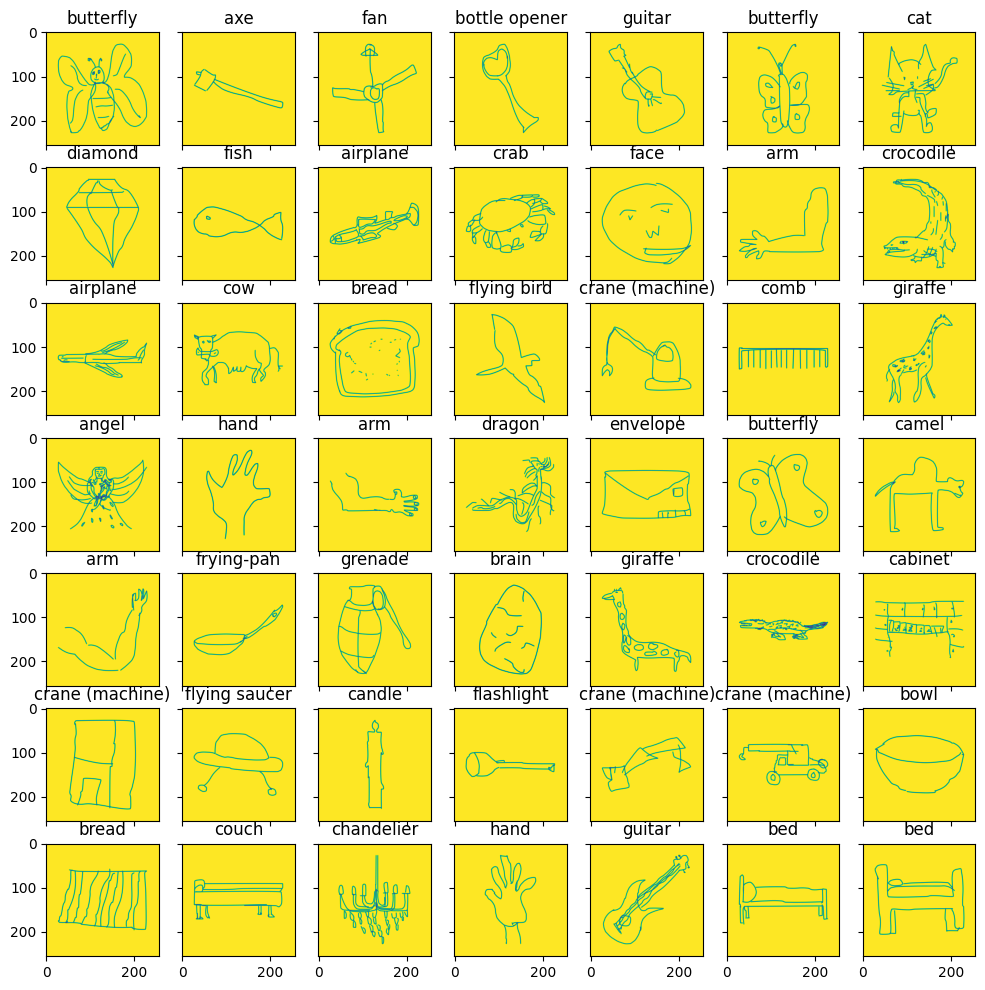

In [5]:
def show_batch(dl: list[tuple[Image, str]], nrows: int, ncols: int):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey=True, sharex=True)
    for idx, fig_x in enumerate(ax.flatten()):
        im, label = dl[idx]
        fig_x.imshow(im[0])
        fig_x.set_title(label)


nrows = 7
ncols = 7
show_batch(random.choices(dataset_list, k=nrows * ncols), nrows=nrows, ncols=ncols)

In [6]:
def show_batch(dl: list, nrows: int, ncols: int):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharey=True, sharex=True)
    for idx, fig_x in tqdm(enumerate(ax.flatten())):
        im, label = dl[idx]
        fig_x.imshow(im[0].reshape((256, -1)))
        fig_x.set_title(dataset.decode_label(label))


start_idx = np.random.randint(0, len(dataset))
nrows = 7
ncols = 7
# show_batch(random.choices([dataset[0], dataset[3]], k=nrows*ncols), nrows=nrows, ncols=ncols)
# show_batch([dataset[idx] for idx in range(start_idx, start_idx + nrows * ncols)], nrows=nrows, ncols=ncols)

In [7]:
aug_for_val = True


def _augmentate(im: Image) -> list[Image]:
    return [
        im.copy(),
        np.flip(im, axis=2).copy(),
        v2.RandomRotation(degrees=(-20, 20), fill=(1, 0, 0))(torch.from_numpy(im)).numpy(),
        # v2.ElasticTransform(alpha=100.0, fill=(1, 0, 0))(torch.from_numpy(im)).numpy(),
        # v2.RandomResizedCrop(size=(256, 256), scale=(0.3, 1.0))(torch.from_numpy(im)).numpy(),
    ]


aug_len = len(_augmentate(dataset[0][0]))


def split(dataset: PhotoDataset, split_pers: float) -> tuple[list[tuple[Image, int]], list[tuple[Image, int]]]:
    x_ds: list[Image, int] = []
    y_ds: list[Image, int] = []

    type_to_image: dict[int, list[int]] = {}
    for idx, img_type in tqdm(enumerate(dataset)):
        img, type = img_type
        if type in type_to_image:
            type_to_image[type].append(idx)
        else:
            type_to_image[type] = [idx]

    for type, idxs in tqdm(type_to_image.items()):
        x_size = int(len(idxs) * split_pers)

        xs = set(np.random.choice(idxs, size=x_size, replace=False))
        newxs = []
        newys = []
        for idx in idxs:
            if idx in xs:
                img, label = dataset[idx]
                augmentations = _augmentate(img)
                for augmentation in augmentations:
                    newxs.append((augmentation, label))

            else:
                if aug_for_val:
                    img, label = dataset[idx]
                    augmentations = _augmentate(img)
                    for augmentation in augmentations:
                        newys.append((augmentation, label))
                else:
                    newys.append(dataset[idx])

        x_ds.extend(newxs)
        y_ds.extend(newys)

        # if len(x_ds) > 400:
        #     break

    return x_ds, y_ds


xs, ys = split(dataset, 0.8)
len(xs), len(ys), round(len(xs) / (len(xs) + len(ys)), 5)

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(19008, 4755, 0.7999)

0it [00:00, ?it/s]

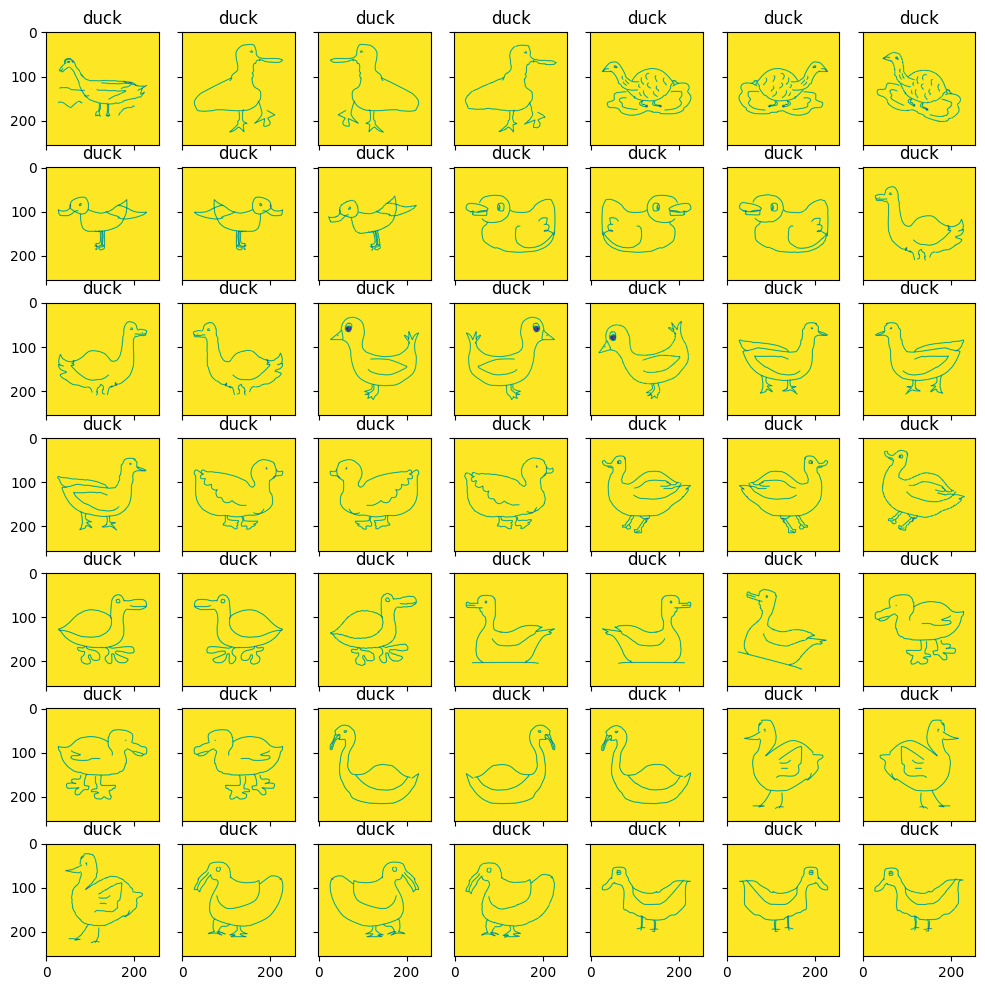

In [8]:
start_idx = np.random.randint(0, len(xs))
nrows = 7
ncols = 7

show_batch([xs[idx] for idx in range(start_idx, start_idx + nrows * ncols)], nrows=nrows, ncols=ncols)

In [9]:
train_ds, val_ds = xs, ys
train_ds_counter = Counter((label for _, label in train_ds))
val_ds_counter = Counter((label for _, label in val_ds))

for label in dataset.labels_unique:
    label_id = dataset.label_encoder.transform([label])[0]
    train_label_count = train_ds_counter[label_id]
    val_label_count = val_ds_counter[label_id]

    print(
        f"{label}: {train_label_count} {val_label_count} ({round(train_label_count/(train_label_count+val_label_count)*100, 3)}%)"
    )

elephant: 192 48 (80.0%)
blimp: 192 48 (80.0%)
duck: 192 48 (80.0%)
bowl: 192 48 (80.0%)
cabinet: 192 48 (80.0%)
cup: 192 48 (80.0%)
bush: 192 48 (80.0%)
floor lamp: 192 48 (80.0%)
beer-mug: 192 48 (80.0%)
grapes: 192 48 (80.0%)
alarm clock: 192 48 (80.0%)
bookshelf: 192 48 (80.0%)
carrot: 192 48 (80.0%)
cactus: 192 48 (80.0%)
chandelier: 192 48 (80.0%)
car (sedan): 192 48 (80.0%)
flashlight: 192 48 (80.0%)
crane (machine): 192 48 (80.0%)
guitar: 192 48 (80.0%)
camera: 192 48 (80.0%)
door handle: 192 48 (80.0%)
bicycle: 192 48 (80.0%)
backpack: 192 48 (80.0%)
frog: 192 48 (80.0%)
bee: 192 48 (80.0%)
crab: 192 48 (80.0%)
bench: 192 48 (80.0%)
candle: 192 48 (80.0%)
cat: 192 48 (80.0%)
bed: 192 48 (80.0%)
donut: 192 48 (80.0%)
fish: 192 48 (80.0%)
dragon: 192 48 (80.0%)
envelope: 192 48 (80.0%)
cow: 192 48 (80.0%)
cake: 192 48 (80.0%)
dolphin: 192 48 (80.0%)
cigarette: 192 48 (80.0%)
door: 192 48 (80.0%)
arm: 192 48 (80.0%)
eye: 192 48 (80.0%)
giraffe: 192 48 (80.0%)
bell: 192 48 (80.0%)

In [10]:
train_loader = DataLoader(
    dataset=train_ds, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory
)
val_loader = DataLoader(
    dataset=val_ds, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory
)

In [11]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
        )
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.AvgPool2d(kernel_size=2),
        # )

        self.fc1 = nn.Sequential(
            nn.LazyLinear(1024),  # 4096
            nn.ReLU(),
            nn.Dropout(0.25),
        )
        self.fc2 = nn.Sequential(
            nn.LazyLinear(2048),  # 8192
            nn.ReLU(),
            nn.Dropout(0.25),
        )

        self.out = nn.LazyLinear(n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # x = self.conv5(x)

        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits

In [12]:
def get_pretrained_resnet(n_classes: int) -> nn.Module:
    model = models.resnet50(pretrained=True).to(DEVICE)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.LazyLinear(n_classes)

    return model

In [13]:
def fit_epoch(model: nn.Module, train_loader: DataLoader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = nn.LogSoftmax(dim=1)(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model: nn.Module, val_loader: DataLoader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            outputs = nn.LogSoftmax(dim=1)(outputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [15]:
def train(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, epochs: int):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
        criterion = nn.NLLLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(
                log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc)
            )

    return history

In [30]:
def predict(model: nn.Module, test_loader: DataLoader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
n_classes = len(dataset.labels_unique)
# model = get_pretrained_resnet(n_classes).to(DEVICE)
model = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(model)

we will classify :100
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv4): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=

In [32]:
# Запуск обучения
history = train(train_loader, val_loader, model=model, epochs=20)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

loss 3.2857005917263353

Epoch 001 train_loss: 3.2857     val_loss 2.7242 train_acc 0.2129 val_acc 0.3359


  0%|          | 0/297 [00:00<?, ?it/s]

loss 2.3165901269174185

Epoch 002 train_loss: 2.3166     val_loss 2.3847 train_acc 0.4104 val_acc 0.4164


  0%|          | 0/297 [00:00<?, ?it/s]

loss 1.769713367677297

Epoch 003 train_loss: 1.7697     val_loss 2.1072 train_acc 0.5252 val_acc 0.4738


  0%|          | 0/297 [00:00<?, ?it/s]

loss 1.4270878733207883

Epoch 004 train_loss: 1.4271     val_loss 2.1136 train_acc 0.6017 val_acc 0.4974


  0%|          | 0/297 [00:00<?, ?it/s]

loss 1.201986303835204

Epoch 005 train_loss: 1.2020     val_loss 2.0426 train_acc 0.6582 val_acc 0.5085


  0%|          | 0/297 [00:00<?, ?it/s]

loss 1.0173422646040868

Epoch 006 train_loss: 1.0173     val_loss 2.0723 train_acc 0.7042 val_acc 0.5203


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.8725484237325714

Epoch 007 train_loss: 0.8725     val_loss 2.1709 train_acc 0.7409 val_acc 0.5136


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.7680061554868615

Epoch 008 train_loss: 0.7680     val_loss 2.1959 train_acc 0.7668 val_acc 0.5169


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.660609521348067

Epoch 009 train_loss: 0.6606     val_loss 2.3739 train_acc 0.7985 val_acc 0.4959


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.6090627018650774

Epoch 010 train_loss: 0.6091     val_loss 2.3359 train_acc 0.8112 val_acc 0.5174


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.5265737153363951

Epoch 011 train_loss: 0.5266     val_loss 2.3939 train_acc 0.8382 val_acc 0.5089


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.5223623903010429

Epoch 012 train_loss: 0.5224     val_loss 2.5193 train_acc 0.8395 val_acc 0.5199


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.46538028938802406

Epoch 013 train_loss: 0.4654     val_loss 2.6739 train_acc 0.8560 val_acc 0.4936


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.4465719735883302

Epoch 014 train_loss: 0.4466     val_loss 2.7431 train_acc 0.8611 val_acc 0.5195


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.432449076261986

Epoch 015 train_loss: 0.4324     val_loss 2.6119 train_acc 0.8665 val_acc 0.5163


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.38452231128910175

Epoch 016 train_loss: 0.3845     val_loss 2.6237 train_acc 0.8807 val_acc 0.5256


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.4148780382442153

Epoch 017 train_loss: 0.4149     val_loss 2.3552 train_acc 0.8732 val_acc 0.5060


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.43157109964375545

Epoch 018 train_loss: 0.4316     val_loss 2.6639 train_acc 0.8670 val_acc 0.5293


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.351538034275124

Epoch 019 train_loss: 0.3515     val_loss 3.0473 train_acc 0.8895 val_acc 0.4934


  0%|          | 0/297 [00:00<?, ?it/s]

loss 0.3574334521988024

Epoch 020 train_loss: 0.3574     val_loss 2.7787 train_acc 0.8872 val_acc 0.5178


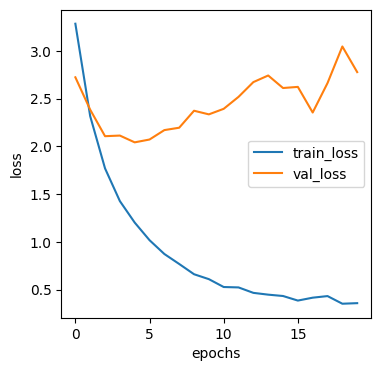

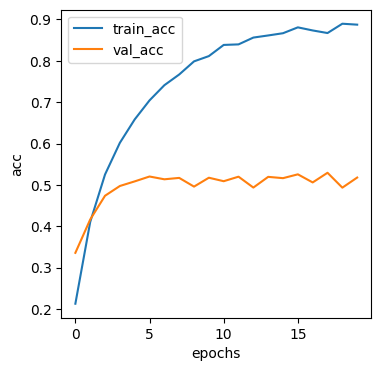

In [33]:
def draw_loss_acc(history):
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(4, 4))
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc="best")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.plot(train_acc, label="train_acc")
    plt.plot([tensor.cpu() for tensor in val_acc], label="val_acc")
    plt.legend(loc="best")
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()


draw_loss_acc(history)

In [21]:
# Save
torch.save(model, model_path)

In [22]:
# Load
# model = get_pretrained_resnet(n_classes).to(DEVICE)
model = torch.load(model_path)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
model.forward(list(val_loader)[0][0].to(DEVICE))

tensor([[-2.3501,  1.7451, -1.6849,  ..., -3.0310, -0.4949, -3.3249],
        [-0.3054, -1.0513, -2.1585,  ..., -0.7778,  0.1301, -2.9798],
        [-0.9031, -0.2103, -1.8299,  ..., -0.8016, -0.3829, -3.4746],
        ...,
        [-1.4214, -1.4282,  0.0826,  ..., -1.8045, -2.7100, -4.4326],
        [-1.8665,  1.2638, -1.5617,  ..., -1.7135, -1.5181, -3.1168],
        [ 1.9588, -2.4558, -1.0195,  ...,  3.1136,  0.3061, -4.3138]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [24]:
_vals = list(val_ds)


def random_images(n: int = 10) -> list[tuple[Image, str]]:
    return random.choices(_vals, k=n)


random_images(n=1)

[(array([[[1.        , 0.75249726, 1.        , ..., 1.        ,
           1.        , 1.        ],
          [1.        , 0.7567329 , 1.        , ..., 1.        ,
           1.        , 1.        ],
          [1.        , 0.7800282 , 1.        , ..., 1.        ,
           1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        , ..., 1.        ,
           1.        , 0.7688425 ],
          [1.        , 1.        , 1.        , ..., 1.        ,
           1.        , 0.7741383 ],
          [1.        , 1.        , 1.        , ..., 1.        ,
           1.        , 0.7763636 ]],
  
         [[0.        , 0.3024698 , 1.        , ..., 1.        ,
           1.        , 1.        ],
          [0.        , 0.33878702, 1.        , ..., 1.        ,
           1.        , 1.        ],
          [0.        , 0.45331463, 1.        , ..., 1.        ,
           1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        , ..., 1.        ,
  

In [25]:
@dataclass
class Prediction:
    real: str
    predicted: str
    conf: float
    img: np.ndarray


def predict(model: nn.Module, inputs: list[tuple[Image, str]]) -> list[Prediction]:
    """Предсказание, для одной картинки"""
    results = []
    for input in inputs:
        with torch.no_grad():
            array = np.array([input[0].tolist()], dtype=input[0].dtype)
            logit = model.forward(torch.from_numpy(array).to(DEVICE)).cpu().numpy()
            # prob = torch.nn.functional.softmax(logit, dim=-1).numpy()

            prediction = Prediction(
                real=dataset.decode_label(input[1]),
                predicted=dataset.decode_label(np.argmax(logit)),
                conf=np.max(logit),
                img=input[0],
            )

            results.append(prediction)
    return results


predict(model, random_images(n=1))

[Prediction(real='fork', predicted='fork', conf=5.805294, img=array([[[1.        , 1.        , 0.9380631 , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 0.93828815, ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 0.9410259 , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [0.99999994, 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ]],
 
        [[0.        , 0.        , 0.8717255 , ..., 1.        ,
          1.        , 1.        ],
         [0.        , 0.        , 0.87220997, ..., 1.        ,
          1.        , 1.        ],
         [0.        , 0.        , 0.87809104, ..., 1.        ,
          1.        , 1.        ],
         ...,
         [1.        , 1.  

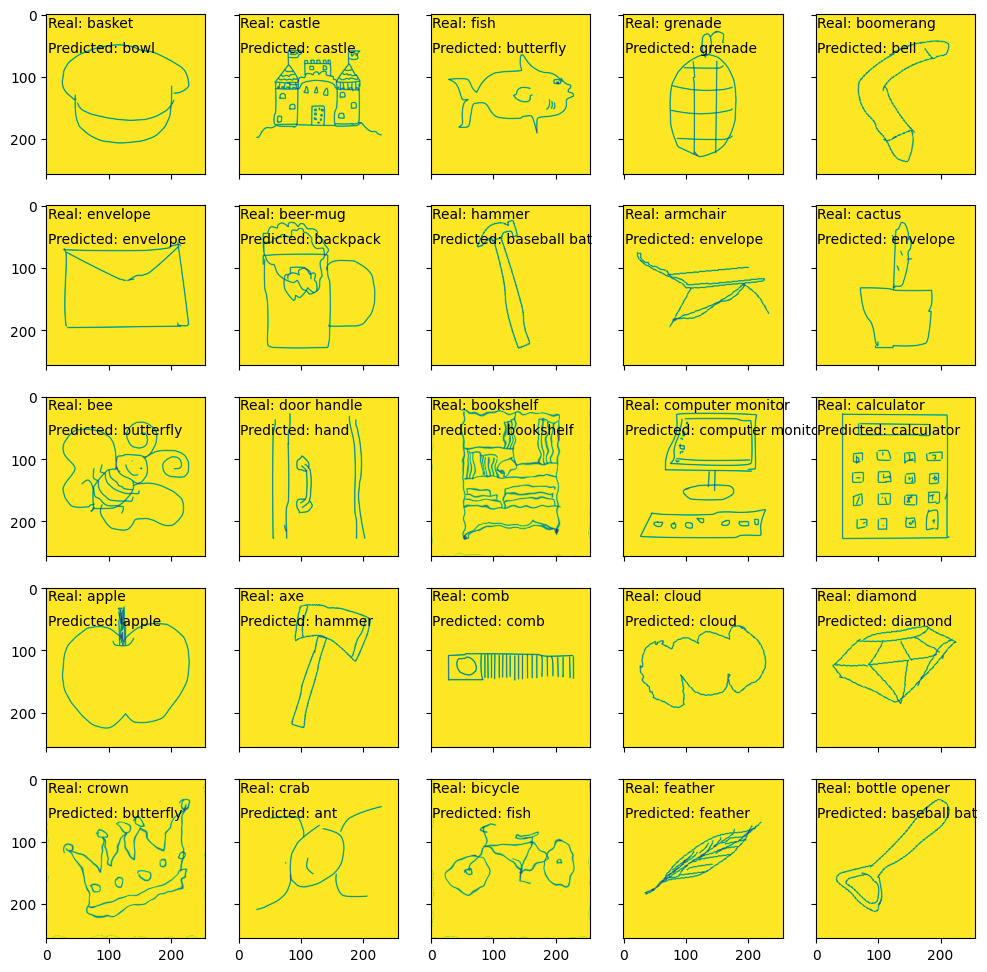

In [26]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties


nrows = 5
ncols = 5
images = random_images(ncols * nrows)
predictions = predict(model, images)

fig, ax = plt.subplots(nrows=ncols, ncols=nrows, figsize=(12, 12), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    img, real_label, predicted_label = predictions[i].img, predictions[i].real, predictions[i].predicted

    fig_x.imshow(img[0].reshape((256, -1)))

    fig_x.text(2, 20, "Real: {}".format(real_label))
    fig_x.text(2, 60, "Predicted: {}".format(predicted_label))